#  Data source: 
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Objectives:
Xây dựng một mô hình có khả năng phát hiện và ấn định xác suất cho các câu bằn tiếng anh với các nhãn:
1. toxic
2. severe toxic
3. obscene
4. threat
5. insult
6. identity hate
Tập dữ liệu bao gồm các bình luận từ các trang thảo luận của Wikipedia.

# Import các thư viện có liên quan và tải dữ liệu từ drive

In [ ]:
# Liên kết với drive để tải dữ liệu
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cài đặt thư viện nltk
!pip install nltk

In [ ]:
#Import một số thư viện thư viện
import matplotlib.pyplot as plt
import nltk
import numpy as np
import re 
import pandas as pd
import string
import seaborn as sns

from nltk.corpus import stopwords 
from nltk.stem.lancaster import LancasterStemmer  
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [ ]:
# Tải xuống stopwords gồm các từ vô nghĩa trong tiếng anh
nltk.download('stopwords')
set(stopwords.words('english'))
set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:
# Tải dữ liệu từ drive
data = pd.read_csv('/content/drive/MyDrive/Data//Data_NLP/train.csv')
# Xem 5 dòng đầu tiên từ dữ liệu vừa tải
data.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Xem thông tin dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# Phân tích dữ liệu

In [ ]:
# Kiểm tra tỉ lệ các nhãn trong dữ liệu
data.toxic.value_counts(normalize=True) 
data.head()
# Tạo một tập hợp con dữ liệu mới bằng cách chỉ lấy cột thứ 2 trở đi (gồm bình luận và nhãn tương ứng)
data_count=data.iloc[:,2:].sum()
data_count

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Trực quan hóa dữ liệu

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


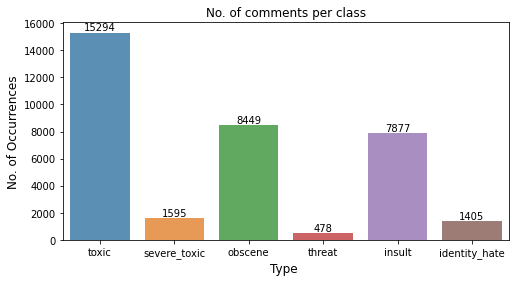

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(8,4))
ax = sns.barplot(data_count.index, data_count.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = data_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [ ]:
num_rows = len(data)
print(num_rows)

159571


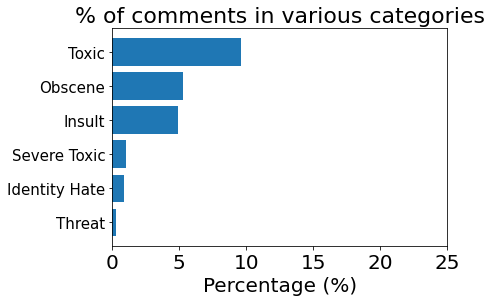

In [ ]:
# Vẽ biểu đồ thanh thể hiện tỉ lệ % của các nhãn
sum_tox = data['toxic'].sum() / num_rows * 100
sum_sev = data['severe_toxic'].sum() / num_rows * 100
sum_obs = data['obscene'].sum() / num_rows * 100
sum_thr = data['threat'].sum() / num_rows * 100
sum_ins = data['insult'].sum() / num_rows * 100
sum_ide = data['identity_hate'].sum() / num_rows * 100

ind = np.arange(6)

ax = plt.barh(ind, [sum_tox, sum_obs, sum_ins, sum_sev, sum_ide, sum_thr])
plt.xlabel('Percentage (%)', size=20)
plt.xticks(np.arange(0, 30, 5), size=20)
plt.title('% of comments in various categories', size=22)
plt.yticks(ind, ('Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 'Threat', ), size=15)

plt.gca().invert_yaxis()
plt.show()

Sử lí dữ liệu (văn bản)

In [ ]:
import re
import string

# Xóa tất cả các số có chữ cái gắn liền với chúng
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - thay dấu câu bằng khoảng trắng
# .lower() - chuyển đổi tất cả các chuỗi thành chữ thường
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Xóa tất cả '\ n' trong chuỗi và thay thế bằng khoảng trắng
remove_n = lambda x: re.sub("\n", " ", x)

# Xóa tất cả các ký tự không phải ascii
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Áp dụng tất cả các hàm lambda đã viết trước đó thông qua .map trên cột nhận xét
data['comment_text'] = data['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

# Kiểm tra 1 câu sau khi xử lí
data['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted  they weren t vandalisms  just closure on some gas after i voted at new york dolls fac  and please don t remove the template from the talk page since i m retired now        '

In [ ]:
# Tách tập dữ liệu của thành 6 phần. Mỗi phần là bình luận + 1 nhãn tương ứng.

data_tox = data.loc[:,['id','comment_text','toxic']]
data_sev = data.loc[:,['id','comment_text','severe_toxic']]
data_obs = data.loc[:,['id','comment_text','obscene']]
data_thr = data.loc[:,['id','comment_text','threat']]
data_ins = data.loc[:,['id','comment_text','insult']]
data_ide = data.loc[:,['id','comment_text','identity_hate']]

data_tox['comment_text'][1]

# Tạo WordCloud
### Để hiển thị các từ xuất hiện thường xuyên nhất cho mỗi danh mục. 

In [ ]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords

In [ ]:
def wordcloud(df, label):
    
    # Chỉ in các hàng có giá trị nhãn danh mục toxic là 1 (tức là nhận xét là toxic)
    subset=df[df[label]==1]
    text=subset.comment_text.values
    wc= WordCloud(background_color="black",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

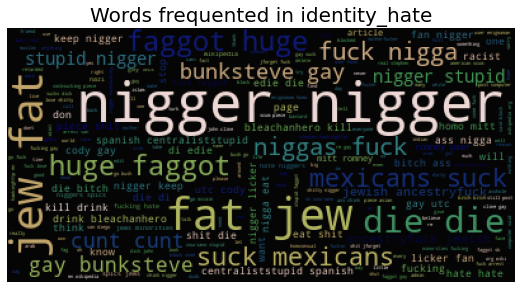

In [ ]:
wordcloud(data_ide,'identity_hate')

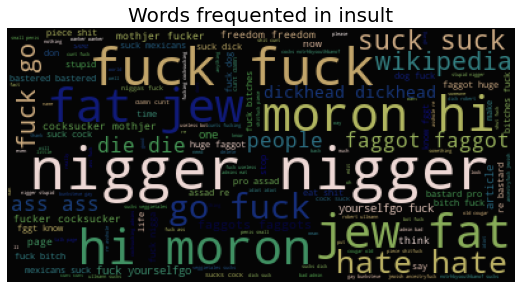

In [ ]:
wordcloud(data_ins, 'insult')

# Cân bằng, điều chỉnh dữ liệu dữ liệu

In [ ]:
data_tox.head()

,id,comment_text,toxic
0,0000997932d777bf,explanation why the edits made under my userna...,0
1,000103f0d9cfb60f,d aww he matches this background colour i m s...,0
2,000113f07ec002fd,hey man i m really not trying to edit war it...,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on im...,0
4,0001d958c54c6e35,you sir are my hero any chance you remember...,0


Chúng ta thấy rằng các nhận xét là toxic (và các dạng toxic khác) chỉ chiếm ít hơn 10% các nhận xét trong dữ liệu. Điều này dẫn đến vấn đề mất cân bằng trong dữ liệu.
Chúng ta có thể giải quyết tình trạng mất cân bằng dữ liệu bằng cách lấy một tập hợp con dữ liệu trong đó tỷ lệ các nhận xét toxic ít nhất là 20% (lý tưởng là 50%) so với các nhận xét không toxic.
Để bắt đầu, chúng ta có thể lấy 5000 hàng nhận xét độc hại và nối chúng theo hàng với những nhận xét không độc hại để chúng ta có một tập dữ liệu cân bằng.

In [ ]:
data_tox_1 = data_tox[data_tox['toxic'] == 1].iloc[0:5000,:]
data_tox_1.shape

(5000, 3)

In [ ]:
data_tox_0 = data_tox[data_tox['toxic'] == 0].iloc[0:5000,:]

In [ ]:
data_tox_done = pd.concat([data_tox_1, data_tox_0], axis=0)
data_tox_done.shape

(10000, 3)

Không phải tất cả các danh mục đều có 5000 hàng. Vì vậy, chúng ta nên đếm chúng trước và làm cho chúng cân bằng.

In [ ]:
data_sev[data_sev['severe_toxic'] == 1].count()

id              1595
comment_text    1595
severe_toxic    1595
dtype: int64

In [ ]:
data_sev_1 = data_sev[data_sev['severe_toxic'] == 1].iloc[0:1595,:]
data_sev_0 = data_sev[data_sev['severe_toxic'] == 0].iloc[0:1595,:]
data_sev_done = pd.concat([data_sev_1, data_sev_0], axis=0)
data_sev_done.shape

(3190, 3)

Chúng ta chỉ có 1.595 bình luận là obscene. Chúng tôi kết hợp nó cùng với 1.595 nhận xét khác không độc hại để tạo thành một tập dữ liệu mới cân bằng. Chúng tôi lặp lại điều này cho tất cả các danh mục khác.

In [ ]:
data_obs[data_obs['obscene'] == 1].count()

id              8449
comment_text    8449
obscene         8449
dtype: int64

In [ ]:
data_obs_1 = data_obs[data_obs['obscene'] == 1].iloc[0:5000,:]
data_obs_0 = data_obs[data_obs['obscene'] == 0].iloc[0:5000,:]
data_obs_done = pd.concat([data_obs_1, data_obs_0], axis=0)
data_obs_done.shape

(10000, 3)

In [ ]:
data_thr[data_thr['threat'] == 1].count()

id              478
comment_text    478
threat          478
dtype: int64

Số lượng bình luận về mối đe dọa là 478 là quá nhỏ khi được thêm vào với 478 bình luận rõ ràng khác để có một phân tích phù hợp. Chúng tôi quyết định rằng các nhận xét rõ ràng sẽ bao gồm tối đa 80% tập dữ liệu, như được hiển thị bên dưới.

In [ ]:
data_thr_1 = data_thr[data_thr['threat'] == 1].iloc[0:478,:]

# Chúng ta có 1912 nhận xét là threat để dữ liệu có mối đe dọa (478) sẽ đại diện cho 20% tập dữ liệu.
data_thr_0 = data_thr[data_thr['threat'] == 0].iloc[0:1912,:]  
data_thr_done = pd.concat([data_thr_1, data_thr_0], axis=0)
data_thr_done.shape

(2390, 3)

In [ ]:
data_ins[data_ins['insult'] == 1].count()

id              7877
comment_text    7877
insult          7877
dtype: int64

In [ ]:
data_ins_1 = data_ins[data_ins['insult'] == 1].iloc[0:5000,:]
data_ins_0 = data_ins[data_ins['insult'] == 0].iloc[0:5000,:]
data_ins_done = pd.concat([data_ins_1, data_ins_0], axis=0)
data_ins_done.shape

(10000, 3)

In [ ]:
data_ide[data_ide['identity_hate'] == 1].count()

id               1405
comment_text     1405
identity_hate    1405
dtype: int64

In [ ]:
data_ide_1 = data_ide[data_ide['identity_hate'] == 1].iloc[0:1405,:] # 20%
data_ide_0 = data_ide[data_ide['identity_hate'] == 0].iloc[0:5620,:] # 80%
data_ide_done = pd.concat([data_ide_1, data_ide_0], axis=0)
data_ide_done.shape

(7025, 3)

# Nhắc nhở: Số lượng nhận xét thuộc các loại sau:

- Toxic (14,000+) 
- Severe Toxic (1595)
- Obscene (8449)
- Threat (478)
- Insult (7877)
- Identity Hate (1405)

#### df _ **** _ done đề cập đến các khung dữ liệu của mỗi lớp đã được cân bằng (tỷ lệ ít nhất 20/80)

# Import các thư viện liên quan để tạo mô hình

In [ ]:
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import các công cụ để chia nhỏ dữ liệu và đánh giá hiệu suất mô hình
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

# Import method ML
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Huấn luyện mô hình và đánh giá

### Huấn luyện mô hình

In [ ]:
def cv_tf_train_test(df_done,label,vectorizer,ngram):
    X = df_done.comment_text
    y = df_done[label]

    # Chia dữ liệu thành dữ liệu train và test 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Tạo một đối tượng Vectorizer và xóa các từ không có nghĩa khỏi bảng
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Học từ vựng từ những dữ liệu train đã xử lí
    X_test_cv1  = cv1.transform(X_test)      # Học từ vựng của tất cả các các từ trong tài liệu thô.
    
    # Xuất khung dữ liệu của CountVectorizer với các từ duy nhất làm nhãn
    # test = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names())
        
    ''' Huấn luyện các mô hình trên các thuật toán máy học bằng dữ liệu train '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)

    bnb = BernoulliNB()
    bnb.fit(X_train_cv1, y_train)
    print('bnb done')
    
    mnb = MultinomialNB()
    mnb.fit(X_train_cv1, y_train)
    print('mnb done')
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Tạo danh sách điểm F1 của tất cả các mô hình
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(bnb.predict(X_test_cv1), y_test), f1_score(mnb.predict(X_test_cv1), y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Tạo DataFrame với tên mô hình làm nhãn cột
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'BernoulliNB', 'MultinomialNB', 'SVM', 'Random Forest'])  

    return df_f1

### Tạo đối tượng vectơ TF-IDF cho từng danh mục và tính điểm F1 trên tất cả các method máy học

In [ ]:
import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(data_tox_done, 'toxic', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

lr done
bnb done
mnb done
rdf done
Time taken: 11.128669500350952 seconds


,F1 Score(toxic)
Log Regression,0.861234
KNN,0.185120
BernoulliNB,0.776521
MultinomialNB,0.874958
SVM,0.876133
Random Forest,0.838055


In [ ]:
t0 = time.time()

df_sev_cv = cv_tf_train_test(data_sev_done, 'severe_toxic', TfidfVectorizer, (1,1))
df_sev_cv.rename(columns={'F1 Score': 'F1 Score(severe_toxic)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)
df_sev_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.994976282119751 seconds


,F1 Score(severe_toxic)
Log Regression,0.927879
KNN,0.857416
BernoulliNB,0.803707
MultinomialNB,0.936170
SVM,0.926004
Random Forest,0.934874


In [ ]:
t0 = time.time()

df_obs_cv = cv_tf_train_test(data_obs_done, 'obscene', TfidfVectorizer, (1,1))
df_obs_cv.rename(columns={'F1 Score': 'F1 Score(obscene)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_obs_cv

lr done
bnb done
mnb done
rdf done
Time taken: 9.972020149230957 seconds


,F1 Score(obscene)
Log Regression,0.908655
KNN,0.519056
BernoulliNB,0.787830
MultinomialNB,0.901463
SVM,0.921378
Random Forest,0.909091


In [ ]:
t0 = time.time()

df_thr_cv = cv_tf_train_test(data_thr_done, 'threat', TfidfVectorizer, (1,1))
df_thr_cv.rename(columns={'F1 Score': 'F1 Score(threat)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_thr_cv

lr done
bnb done
mnb done
rdf done
Time taken: 1.3098187446594238 seconds


,F1 Score(threat)
Log Regression,0.628821
KNN,0.720000
BernoulliNB,0.311828
MultinomialNB,0.504762
SVM,0.786765
Random Forest,0.795539


In [ ]:
t0 = time.time()

df_ins_cv = cv_tf_train_test(data_ins_done, 'insult', TfidfVectorizer, (1,1))
df_ins_cv.rename(columns={'F1 Score': 'F1 Score(insult)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ins_cv

lr done
bnb done
mnb done
rdf done
Time taken: 10.299081087112427 seconds


,F1 Score(insult)
Log Regression,0.896599
KNN,0.257992
BernoulliNB,0.783762
MultinomialNB,0.897411
SVM,0.902619
Random Forest,0.883993


In [ ]:
t0 = time.time()

df_ide_cv = cv_tf_train_test(data_ide_done, 'identity_hate', TfidfVectorizer, (1,1))
df_ide_cv.rename(columns={'F1 Score': 'F1 Score(identity_hate)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_ide_cv

lr done
bnb done
mnb done
rdf done
Time taken: 5.661269664764404 seconds


,F1 Score(identity_hate)
Log Regression,0.699029
KNN,0.230159
BernoulliNB,0.549206
MultinomialNB,0.485857
SVM,0.797516
Random Forest,0.768448


In [ ]:
# Kết hợp các khung dữ liệu thành một khung dữ liệu chính để so sánh điểm F1 trên tất cả các danh mục.
f1_all = pd.concat([df_tox_cv, df_sev_cv, df_obs_cv, df_ins_cv, df_thr_cv, df_ide_cv], axis=1)
f1_all

,F1 Score(toxic),F1 Score(severe_toxic),F1 Score(obscene),F1 Score(insult),F1 Score(threat),F1 Score(identity_hate)
Log Regression,0.861234,0.927879,0.908655,0.896599,0.628821,0.699029
KNN,0.185120,0.857416,0.519056,0.257992,0.720000,0.230159
BernoulliNB,0.776521,0.803707,0.787830,0.783762,0.311828,0.549206
MultinomialNB,0.874958,0.936170,0.901463,0.897411,0.504762,0.485857
SVM,0.876133,0.926004,0.921378,0.902619,0.786765,0.797516
Random Forest,0.838055,0.934874,0.909091,0.883993,0.795539,0.768448


### Vẽ biểu đồ thẻ hiện Score F1 của các Model đã train

In [ ]:
# Chuyển đổi khung dữ liệu F1 kết hợp để phù hợp với việc trình bày trên biểu đồ
f1_all_trp = f1_all.transpose()
f1_all_trp

,Log Regression,KNN,BernoulliNB,MultinomialNB,SVM,Random Forest
F1 Score(toxic),0.861234,0.185120,0.776521,0.874958,0.876133,0.838055
F1 Score(severe_toxic),0.927879,0.857416,0.803707,0.936170,0.926004,0.934874
F1 Score(obscene),0.908655,0.519056,0.787830,0.901463,0.921378,0.909091
F1 Score(insult),0.896599,0.257992,0.783762,0.897411,0.902619,0.883993
F1 Score(threat),0.628821,0.720000,0.311828,0.504762,0.786765,0.795539
F1 Score(identity_hate),0.699029,0.230159,0.549206,0.485857,0.797516,0.768448


Text(0.5, 1.0, 'F1 Score of ML models (TF-IDF)')

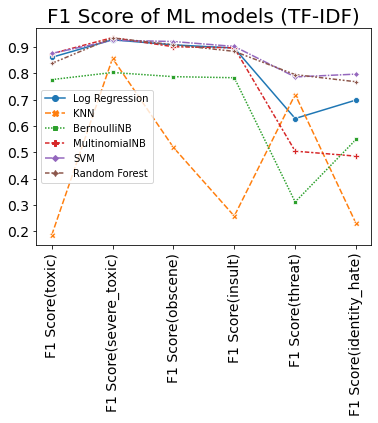

In [ ]:
# Vẽ biểu đồ
sns.lineplot(data=f1_all_trp, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score of ML models (TF-IDF)', fontsize=20)


Mô hình LinearSVC và Random Forest hoạt động tốt nhất (các đường màu tím và nâu dường như là cao nhất).

# Kiểm tra xem chương có thực sự hoạt động hay không. Xác suất nhận xét thuộc nhiều loại khác nhau sẽ được xuất ra.

In [ ]:
data_tox_done.head()

,id,comment_text,toxic
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1
12,0005c987bdfc9d4b,hey what is it talk what is it a...,1
16,0007e25b2121310b,bye don t look come or think of comming ba...,1
42,001810bf8c45bf5f,you are gay or antisemmitian archangel whit...,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1


In [ ]:
X = data_tox_done.comment_text
y = data_tox_done['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Khởi tạo công cụ vecto Tfidf
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Chuyển đổi dữ liệu X thành dữ liệu matrix dataframe
X_test_fit = tfv.transform(X_test)  # Chuyển đổi các nhận xét X_test sang định dạng Vectorized

randomforest = RandomForestClassifier(n_estimators=100, random_state=42)

# Đào tạo mô hình SVM của chúng tôi với dữ liệu đào tạo X được chuyển đổi thành định dạng Count Vectorized với dữ liệu đào tạo Y.
randomforest.fit(X_train_fit, y_train)
randomforest.predict(X_test_fit)

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# Dự đoán mẫu
comment1 = ['You piece of shit']
comment2 = ['What is up garden apple doing']

comment1_vect = tfv.transform(comment1)
randomforest.predict_proba(comment1_vect)[:,1]

array([1.])

In [ ]:
comment2_vect = tfv.transform(comment2)
randomforest.predict_proba(comment2_vect)[:,1]

array([0.16036935])

# Chọn mẫu RandomForest được đào tạo cho tất cả các danh mục.


Chọn Random Forest thay vì LinearSVC mặc dù sau này hoạt động tốt, vì RDF có chức năng dự đoán_proba và LinearSVC thì không. Chúng ta cần đưa ra điểm xác suất cho mỗi nhận xét.

### Lưu Model

In [ ]:
import pickle

In [ ]:
def pickle_model(df, label):
    
    X = df.comment_text
    y = df[label]

    # Khởi tạo công cụ vecto Tfidf
    tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
    
    X_vect = tfv.fit_transform(X)  
    
    # Lưu các nhãn cột (tức là từ vựng)
    # wb có nghĩa là Ghi vào tệp ở chế độ Nhị phân, được viết bằng các đối tượng byte
    with open(r"{}.pkl".format(label + '_vect'), "wb") as f:   
        pickle.dump(tfv, f)   
        
    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_vect, y)

    # Tạo một new pickle file trên random forest
    with open(r"{}.pkl".format(label + '_model'), "wb") as f:  
        pickle.dump(randomforest, f)
